<a href="https://colab.research.google.com/github/Milonahmed96/Credit-Risk-AI/blob/main/notebooks/03_tree_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Modeling Setup & Data Loading
While Logistic Regression provides a strong, interpretable baseline, credit behavior often contains non-linear relationships (e.g., the compounding risk of high utilization combined with late payments). In this phase, we train an XGBoost classifier to capture these complex interactions.

First, we mount our Google Drive to load the engineered datasets seamlessly without manual uploads.

In [1]:
# Install shap
!pip -q install shap xgboost

# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import xgboost as xgb
import shap
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.family': 'sans-serif', 'axes.titlesize': 14, 'axes.titleweight': 'bold', 'figure.dpi': 120})
sns.set_style("whitegrid")

# Mount Google Drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Ahmed Intelligence/AI for Banking and Fintech'

# Load the datasets
train_data = pd.read_csv(f'{project_path}/train_processed.csv')
test_data = pd.read_csv(f'{project_path}/test_processed.csv')

X_train = train_data.drop('default', axis=1)
y_train = train_data['default']
X_test = test_data.drop('default', axis=1)
y_test = test_data['default']

Mounted at /content/drive
Loading engineered datasets from Google Drive...
✅ Data loaded successfully!


# Leakage-Safe Pipeline Construction
To ensure this model is production-ready, we utilize a `scikit-learn` Pipeline. This guarantees that imputation, scaling, and encoding happen dynamically, preventing any data leakage from the test set into the training set.

We address the 22% class imbalance using the `scale_pos_weight` parameter, which is the gradient boosting equivalent of class weights. Finally, we save the trained pipeline using `joblib` for future deployment.

In [2]:
# Define feature groups
categorical_cols = ['sex', 'education', 'marriage']
continuous_cols = [col for col in X_train.columns if col not in categorical_cols]

# Build the Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), continuous_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), categorical_cols)
])

# Calculate class weight for imbalance
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Build XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=class_ratio,
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        eval_metric='logloss'
    ))
])

# Train and Save
xgb_pipeline.fit(X_train, y_train)
joblib.dump(xgb_pipeline, f'{project_path}/xgboost_model_pipeline.pkl')

Training Leakage-Safe XGBoost Pipeline...
✅ XGBoost Pipeline trained and saved permanently to Google Drive!


# Model Evaluation
We evaluate the XGBoost model using the same banking-specific metrics applied to the baseline model (ROC-AUC and PR-AUC) to determine if the non-linear algorithm provides a measurable lift in distinguishing default risk.

In [3]:
# Generate predictions
y_pred_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_default_xgb = xgb_pipeline.predict(X_test)

roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_prob_xgb)

print("XGBoost Pipeline Evaluation Metrics")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"PR-AUC Score:  {pr_auc_xgb:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_default_xgb, target_names=['Non-Default (0)', 'Default (1)']))

XGBoost Pipeline Evaluation Metrics
ROC-AUC Score: 0.7803
PR-AUC Score:  0.5561

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.88      0.78      0.83      4673
    Default (1)       0.45      0.63      0.53      1327

       accuracy                           0.75      6000
      macro avg       0.67      0.71      0.68      6000
   weighted avg       0.79      0.75      0.76      6000



# Global Explainability via SHAP
Gradient boosting models are historically viewed as "black boxes," which is unacceptable in regulatory finance. We utilize SHAP (SHapley Additive exPlanations) to decompose the model's predictions.

Because we used a pipeline, we must dynamically extract the transformed feature names and pass the scaled data into the SHAP explainer. The resulting summary plot illustrates both feature importance (y-axis) and the directional impact of feature values on the default probability (color and x-axis).

Extracting feature names and transforming data for SHAP...
Calculating SHAP values...


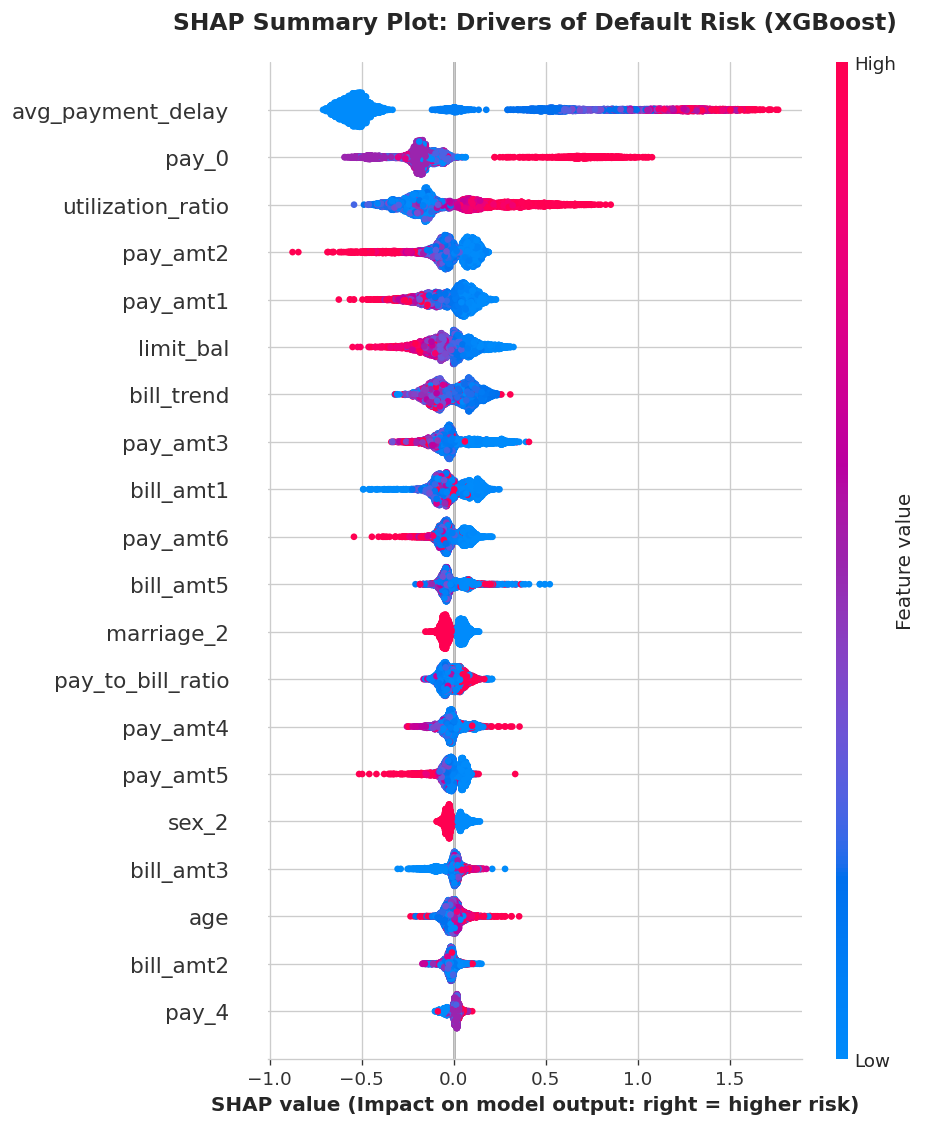

In [4]:
# Extract feature names from the pipeline
cat_encoder = xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = continuous_cols + list(cat_features)

# Transform the test data manually (SHAP needs the scaled/encoded numbers, not the raw text)
X_test_transformed = xgb_pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Initialize SHAP Explainer directly on the XGBoost classifier step
xgb_model = xgb_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(xgb_model)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_transformed_df)

# Visualize
plt.figure(figsize=(10, 8))
plt.title("SHAP Summary Plot: Drivers of Default Risk (XGBoost)", fontweight='bold', fontsize=14, pad=20)
shap.summary_plot(shap_values, X_test_transformed_df, show=False)

fig = plt.gcf()
fig.set_dpi(120)
plt.xlabel("SHAP value (Impact on model output: right = higher risk)", fontsize=12, fontweight='bold')
plt.show()